# Building a GAN to generate Anime faces

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [3]:
import os 
DATA_DIR = '/kaggle/input/animefaces-512x512'
print(os.listdir(DATA_DIR))

['anime_face']


In [4]:
print(f"No of anime faces in the dataset : {len(os.listdir('/kaggle/input/animefaces-512x512/anime_face'))}")

No of anime faces in the dataset : 140000


In [5]:
from PIL import Image

img = Image.open('/kaggle/input/animefaces-512x512/anime_face/' + os.listdir('/kaggle/input/animefaces-512x512/anime_face')[0])
print('size of each image in the dataset is : ',img.size)

size of each image in the dataset is :  (512, 512)


In [6]:
image_size = 64 #change the size of image from (512,512) to (64,64)
batch_size = 128 # size of batch for training
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
train_data = ImageFolder(DATA_DIR,transform = transforms.Compose(
    [transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)]))

In [8]:
train_loader = DataLoader(train_data,batch_size,shuffle=True,num_workers = 2)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64,cp = False):
    if cp == True:
        images = images.cpu()
    fig , ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow = 8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax,cp = True)
        break

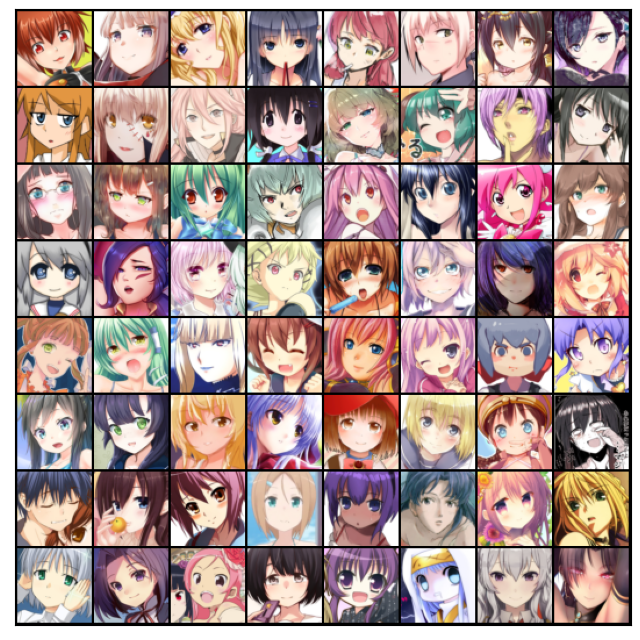

In [10]:
show_batch(train_loader)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_loader = DeviceDataLoader(train_loader, device)

## Discriminator Network

In [14]:
#hyperparameters
nc = 3 #no  of channels in training images.
latent_size = 100 # size of latent vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator
num_epochs = 30# no of epochs the training is done
lr = 0.0002 # learning rate for Adam
beta1 = 0.5 # beta1 hyperparameter of Adam Optimizer


In [15]:
#nc = 3 , ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
        self.main = to_device(self.main,device)
    def forward(self, input):
        return self.main(input)

In [16]:
netD = Discriminator().to(device)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

## Generator Network

In [38]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d( latent_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )
        self.main = to_device(self.main,device)
    def forward(self, input):
        return self.main(input)

In [39]:
netG = Generator().to(device)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


torch.Size([128, 3, 64, 64])


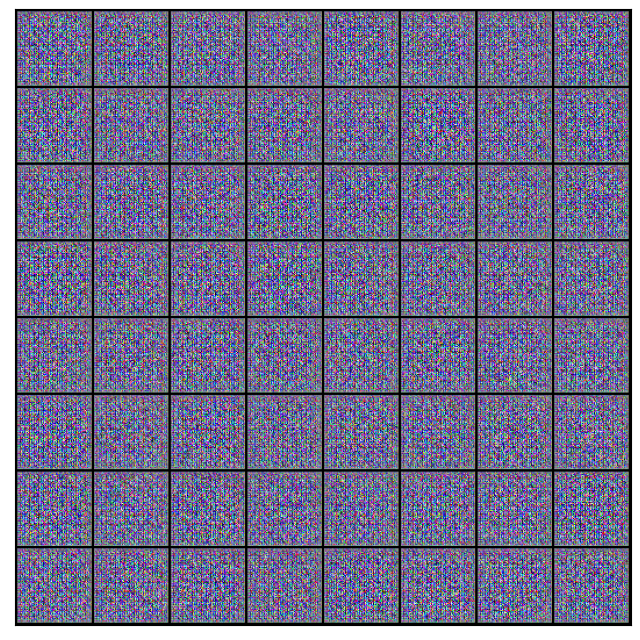

In [19]:
xb = torch.randn(batch_size , latent_size , 1 , 1,device = device)
fake_images = netG.forward(xb)
print(fake_images.shape)
show_images(fake_images,cp = True)

## Discriminator Training

In [20]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    
    #Pass real images through discriminator
    real_preds = netD.forward(real_images)
    real_targets = torch.ones(real_images.size(0),1,device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #Generate FakeImages
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = netG.forward(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = netD(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

In [21]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1,device = device)
    fake_images = netG.forward(latent)
    
    #try to fool the discriminator
    preds = netD.forward(fake_images)
    targets = torch.ones(batch_size , 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok = True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = netG.forward(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [49]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


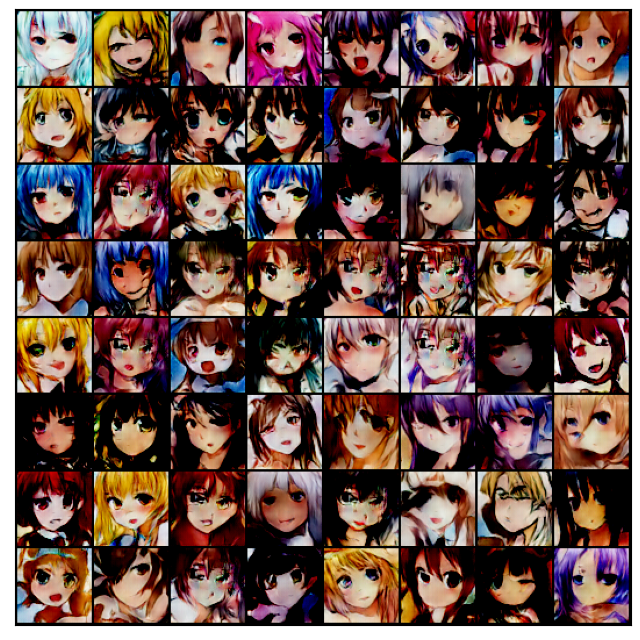

In [51]:
save_samples(0, fixed_latent)

## Training Loop

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr,beta1, start_idx = 1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    opt_g = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            loss_d , real_score , fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
        
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores,fake_scores

In [ ]:
history = fit(num_epochs,lr,beta1)

In [ ]:
torch.save(netG.state_dict(),'G.pth')
torch.save(netD.state_dict(),'D.pth')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0030.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [40]:
netG.state_dict().keys()

odict_keys(['main.0.weight', 'main.1.weight', 'main.1.bias', 'main.1.running_mean', 'main.1.running_var', 'main.1.num_batches_tracked', 'main.3.weight', 'main.4.weight', 'main.4.bias', 'main.4.running_mean', 'main.4.running_var', 'main.4.num_batches_tracked', 'main.6.weight', 'main.7.weight', 'main.7.bias', 'main.7.running_mean', 'main.7.running_var', 'main.7.num_batches_tracked', 'main.9.weight', 'main.10.weight', 'main.10.bias', 'main.10.running_mean', 'main.10.running_var', 'main.10.num_batches_tracked', 'main.12.weight'])

In [41]:
netG.load_state_dict(torch.load('/kaggle/input/gen-anime-weights/G.pth'))

<All keys matched successfully>

In [58]:
latent = torch.randn(1, latent_size, 1, 1, device=device)
image = netG.forward(latent)
save_image(denorm(image),'hehehe.jpg')

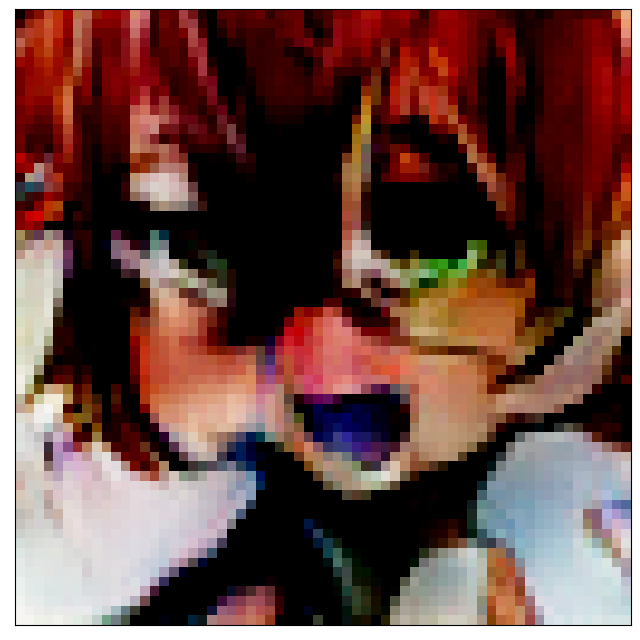

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(image[0].cpu().permute(1,2,0).detach().numpy())